In [21]:
!pip3 install tensorflow

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

In [24]:
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [103]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    axs[0].plot(range(1, len(model_history.history['acc'])+1),
               model_history.history['acc'])
    axs[0].plot(range(1, len(model_history.history['val_acc'])+1),
               model_history.history['val_acc'])
    axs[0].set_title('Model Accuacy')
    axs[0].set_title('Accuracy')
    axs[0].set_title('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),
                               len(model_history.history['acc'])/10)
    axs[0].legend(['train','val'], loc='best')
    axs[1].plot(range(1, len(model_history.history['loss'])+1),
               model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss'])+1),
               model_history.history['val_loss'])
    axs[1].set_title('Model Accuacy')
    axs[1].set_title('Accuracy')
    axs[1].set_title('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),
                               len(model_history.history['loss'])/10)
    axs[1].legend(['train','val'], loc='best')
    plt.show()   

In [47]:
base_skin_dir = os.path.join('/home/sherlock/Rushi/SkinCareMNIST/skin-cancer-mnist-ham10000')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]:x
                    for x in glob(os.path.join(base_skin_dir,'*','*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [48]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [49]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /home/sherlock/Rushi/SkinCareMNIST/skin-cancer...   
1  /home/sherlock/Rushi/SkinCareMNIST/skin-cancer...   
2  /home/sherlock/Rushi/SkinCareMNIST/skin-cancer...   
3  /home/sherlock/Rushi/SkinCareMNIST/skin-cancer...   
4  /home/sherlock/Rushi/SkinCareMNIST/skin-cancer...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

In [50]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [51]:
skin_df['age'].fillna((skin_df['age'].mean()),inplace=True)

In [52]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [53]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


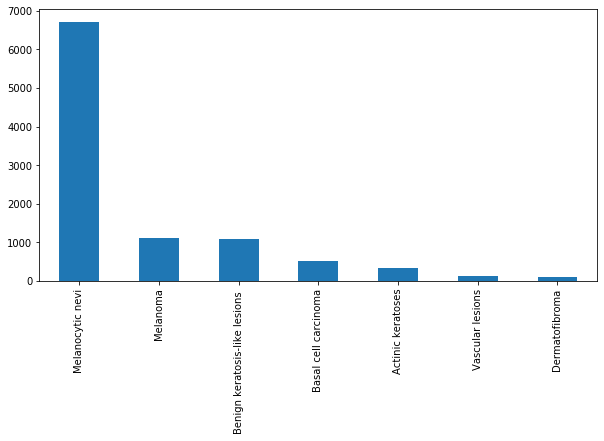

In [64]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
skin_df['cell_type'].value_counts().plot(kind = 'bar', ax = ax1)

Its seems from the above plot that in this dataset cell type Melanecytic nevi has very large number of instances in comparison to other cell types

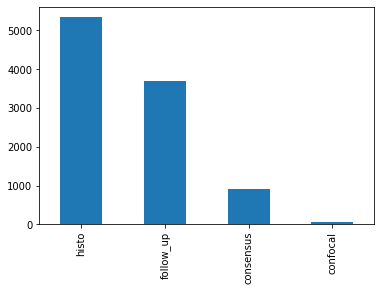

In [65]:
skin_df['dx_type'].value_counts().plot(kind='bar')

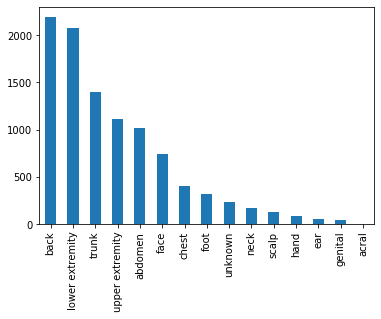

In [66]:
skin_df['localization'].value_counts().plot(kind='bar')

It seems back , lower extremity,trunk and upper extremity are heavily compromised regions of skin cancer

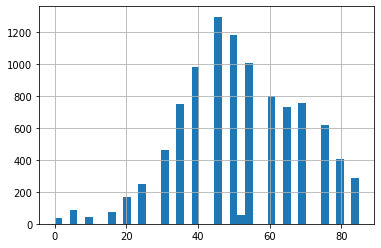

In [67]:
skin_df['age'].hist(bins=40)

It seems that there are larger instances of patients having age from 30 to 60

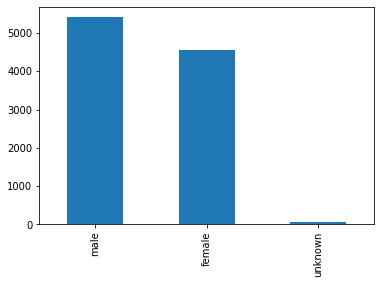

In [69]:
skin_df['sex'].value_counts().plot(kind='bar')

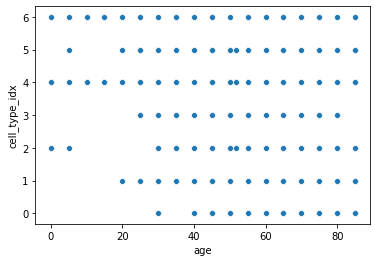

In [71]:
sns.scatterplot('age', 'cell_type_idx', data=skin_df)

It seems that skin cancer types 0,1, 3 and 5 which are Melanocytic nevi,dermatofibroma,Basal cell carcinoma and Vascular lesions are not much prevalant below the age of 20 years

In [74]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [75]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /home/sherlock/Rushi/SkinCareMNIST/skin-cancer...   
1  /home/sherlock/Rushi/SkinCareMNIST/skin-cancer...   
2  /home/sherlock/Rushi/SkinCareMNIST/skin-cancer...   
3  /home/sherlock/Rushi/SkinCareMNIST/skin-cancer...   
4  /home/sherlock/Rushi/SkinCareMNIST/skin-cancer...   

                        cell_type  cell_type_idx  \
0  Benign keratosis-like lesions               2   
1  Benign keratosis-like lesions               2   
2  Benign keratosis-like lesions               2   
3  Benign keratosis-like lesions               2   
4  Benign keratosis-like lesions               2   

                                               image  
0  [[[191, 153, 194], [191, 154, 198], [189, 152,...  
1  [[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3...  
2  [[[186, 126, 136], [190, 136, 149], [195, 137,...  
3  [[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6...  
4  [[[136, 91, 114], [148, 104, 127], [161, 117, ...

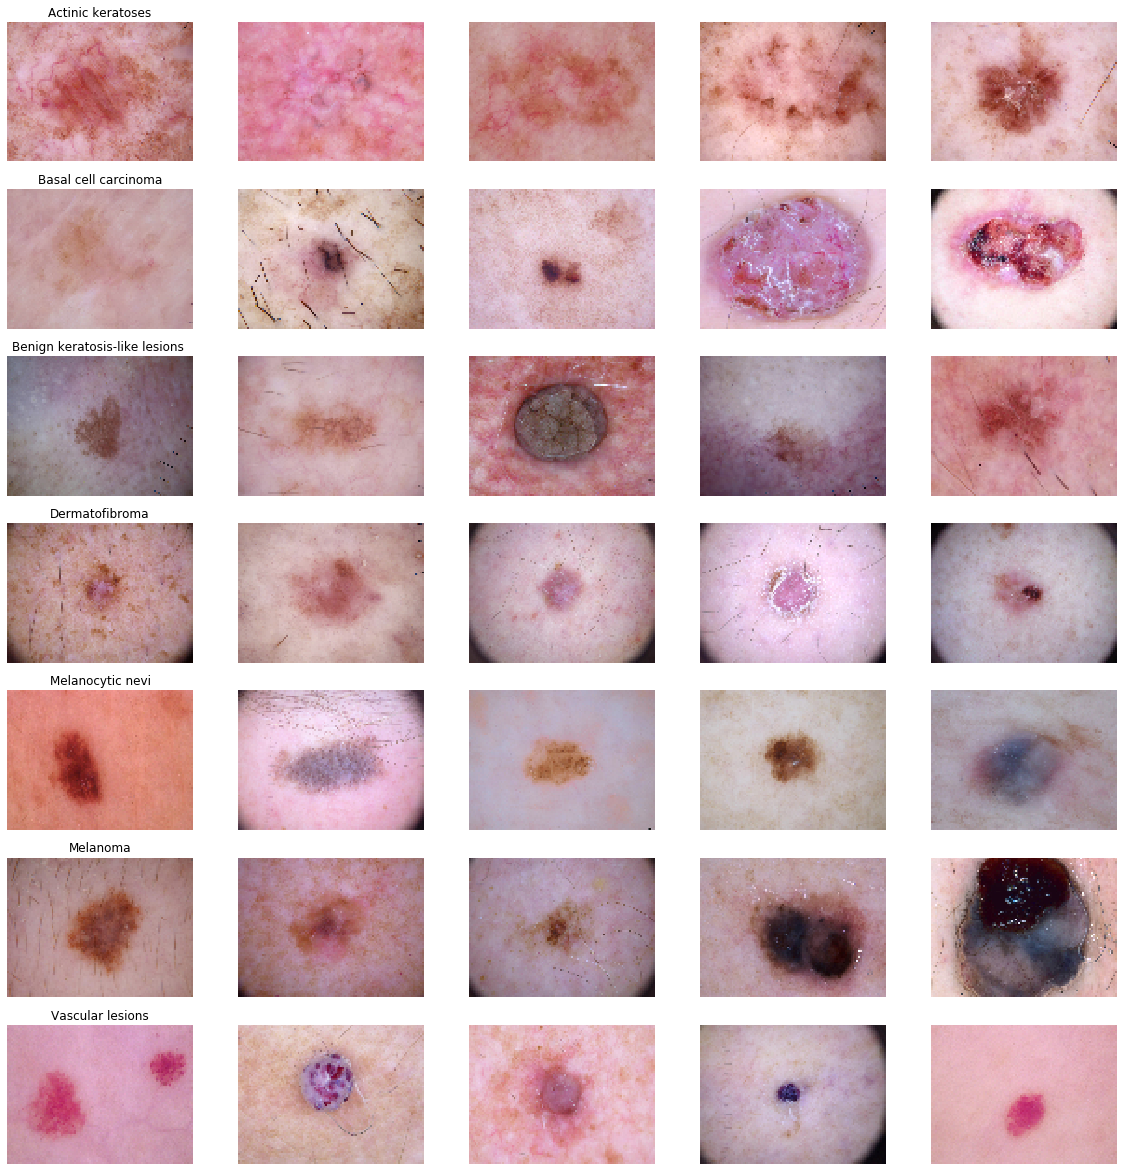

In [76]:
n_samples= 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, skin_df.sort_values
                                        (['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_,c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_sample.png', dpi=300)

In [78]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [80]:
features = skin_df.drop(columns=['cell_type_idx'], axis=1)
target = skin_df['cell_type_idx']

In [86]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, 
                                                   target, test_size=0.20, random_state=1234)

In [87]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_test_mean = np.mean(x_test)

x_train_std = np.std(x_train)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [88]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [89]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train,
                                                            y_train, test_size = 0.1, random_state = 2)

In [90]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [91]:
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32,kernel_size = (3, 3), activation='relu',
                 padding = 'Same', input_shape = input_shape))
model.add(Conv2D(32,kernel_size = (3, 3), activation='relu',
                 padding = 'Same'))
model.add(MaxPool2D(pool_size= (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size = (3, 3), activation='relu',
                 padding = 'Same'))
model.add(Conv2D(64,kernel_size = (3, 3), activation='relu',
                 padding = 'Same'))
model.add(MaxPool2D(pool_size= (2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))
model.summary()


W0827 00:48:59.229959 140331783468864 deprecation_wrapper.py:119] From /home/sherlock/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 00:49:00.067893 140331783468864 deprecation_wrapper.py:119] From /home/sherlock/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 00:49:00.222141 140331783468864 deprecation_wrapper.py:119] From /home/sherlock/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 00:49:00.600777 140331783468864 deprecation_wrapper.py:119] From /home/sherlock/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0827 00:49

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 64)       

In [92]:
optimizer = Adam(lr=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None,
                decay = 0.0, amsgrad = False)

In [93]:
model.compile(optimizer= optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

W0827 00:55:35.552181 140331783468864 deprecation_wrapper.py:119] From /home/sherlock/.local/lib/python3.6/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0827 00:55:35.575817 140331783468864 deprecation_wrapper.py:119] From /home/sherlock/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.



In [94]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',
                                           patience = 3,
                                           verbose = 1,
                                           factor = 0.5,
                                           min_lr = 0.00001)

In [95]:
datagen = ImageDataGenerator(featurewise_center = False,
                            samplewise_center = False,
                            featurewise_std_normalization = False,
                            samplewise_std_normalization = False,
                            zca_whitening = False,
                            rotation_range = 10,
                            zoom_range = 0.1,
                            width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            horizontal_flip = False,
                            vertical_flip = False)

datagen.fit(x_train)

In [98]:
epochs = 50
batch_size = 10
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
                             epochs = epochs, validation_data = (x_validate, y_validate),
                             verbose = 1, steps_per_epoch = x_train.shape[0] // batch_size,
                             callbacks = [learning_rate_reduction])

W0827 01:08:45.815927 140331783468864 deprecation.py:323] From /home/sherlock/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
  5/721 [..............................] - ETA: 73:19:37 - loss: 1.4665 - acc: 0.5800  ETA: 180:50:50 - loss: 1.6851 - acc: 0.45 - ETA: 122:04:35 - loss: 1.8014 - acc: 0.5

/home/sherlock/.local/lib/python3.6/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.495257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/721 [..............................] - ETA: 61:03:12 - loss: 1.4247 - acc: 0.5833

/home/sherlock/.local/lib/python3.6/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.801672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/721 [..............................] - ETA: 28:11:35 - loss: 1.3473 - acc: 0.6333- ETA: 41:48:26 - loss: 1.3111 - acc: 0.640 - ETA: 38:12:23 - loss: 1.3125 - acc: 0.645 - ETA: 35:11:38 - loss: 1.3818 - acc: 0.6

/home/sherlock/.local/lib/python3.6/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.357624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/721 [..............................] - ETA: 23:24:11 - loss: 1.3498 - acc: 0.6278

/home/sherlock/.local/lib/python3.6/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.357607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


721/721 [==============================] - 2359s 3s/step - loss: 0.9991 - acc: 0.6666 - val_loss: 0.9736 - val_acc: 0.6820
Epoch 2/50
721/721 [==============================] - 192s 267ms/step - loss: 0.9269 - acc: 0.6720 - val_loss: 0.8819 - val_acc: 0.6845
Epoch 3/50
721/721 [==============================] - 189s 262ms/step - loss: 0.9021 - acc: 0.6775 - val_loss: 0.8443 - val_acc: 0.6983
Epoch 4/50
721/721 [==============================] - 189s 262ms/step - loss: 0.8584 - acc: 0.6872 - val_loss: 0.7845 - val_acc: 0.7132
Epoch 5/50
721/721 [==============================] - 189s 262ms/step - loss: 0.8429 - acc: 0.6965 - val_loss: 0.7798 - val_acc: 0.6970
Epoch 6/50
721/721 [==============================] - 188s 261ms/step - loss: 0.8209 - acc: 0.6996 - val_loss: 0.7352 - val_acc: 0.7294
Epoch 7/50
721/721 [==============================] - 190s 263ms/step - loss: 0.8000 - acc: 0.7067 - val_loss: 0.7209 - val_acc: 0.7332
Epoch 8/50
721/721 [==============================] - 189s 26

In [100]:
loss, accuracy = model.evaluate(x_test, y_test, verbose = 1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose = 1)
print("Validation: Accuracy = %f ; loss_v = %f" %(accuracy_v, loss_v))
print("Test: Accuracy = %f ; loss_v = %f" %(accuracy, loss))
model.save("model.h5")

802/802 [==============================] - 3s 4ms/step
Validation: Accuracy = 0.771820 ; loss_v = 0.611397
Test: Accuracy = 0.755866 ; loss_v = 0.629274


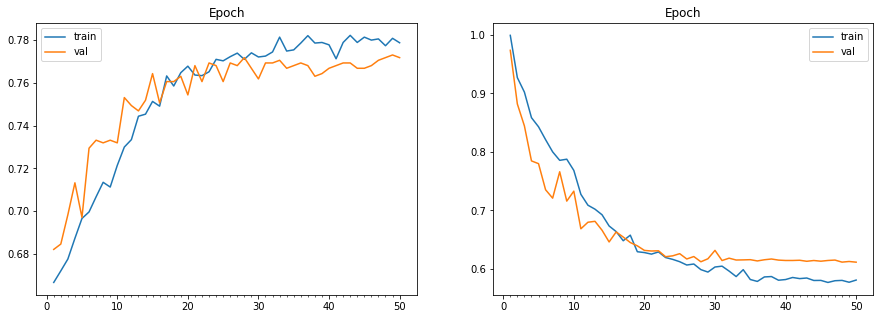

In [104]:
plot_model_history(history)

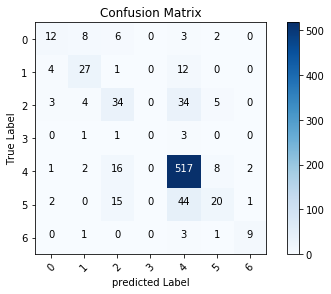

In [107]:
def plot_confusion_matrix(cm, classes, normalize = False,
                         title = 'Confusion Matrix',
                         cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks =np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.xticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment = 'center',
                color = 'white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('predicted Label')
    
Y_pred = model.predict(x_validate)

Y_pred_classes = np.argmax(Y_pred, axis =1)

Y_true = np.argmax(y_validate, axis = 1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes = range(7))

Text(0, 0.5, 'Fraction classified incorrectly')

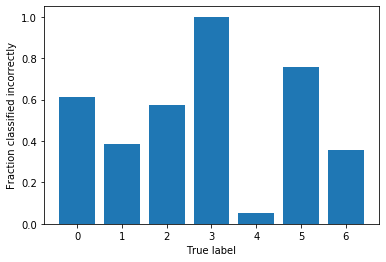

In [108]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis = 1)
plt.bar(np.arange(7), label_frac_error)
plt.xlabel('True label')
plt.ylabel('Fraction classified incorrectly')